In [4]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
import shap
shap.initjs()

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
rcParams['font.size']= 8

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import csv, re
from sklearn.model_selection import train_test_split

Предсказать 4 target значения на основе данных сигнала

In [5]:
train_ds=pd.read_csv("C:\\train_data_200k.csv", delimiter=',')
test_ds=pd.read_csv("C:\\test_data_100k.csv", delimiter=',')

In [26]:
train_ds.shape

(200000, 84)

In [27]:
test_ds.shape

(100000, 80)

In [6]:
train_ds.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,100168.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,39220.000000,38048.000000,1.583080e+05,152970.000000,15578.000000,1407.000000,1.998630e+05,199867.000000,1.117250e+05,1.138000e+05,98410.0,1.998670e+05,132355.000000,199866.000000,78120.000000,14722.000000,101792.000000,84189.000000,59443.000000,199867.000000,199837.000000,199867.000000,199837.000000,199119.000000,199875.000000,35810.000000,36726.000000,199875.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,37652.000000,199867.000000,199867.000000,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,20.305728,11.696598,13.797841,11.759747,81.016135,19.222866,8.782267,10.878145,20.160856,17.093377,25.379681,26.202377,20.609791,5.374740,19.468993,10.680114,23.355227,35.503725,34.075806,7.990204e+01,59.421573,40.916190,9.436213,1.297079e+01,156.896997,1.761049e+01,1.316814e+00,0.0,1.848092e+02,245.337823,69.513164,43.837855,45.891781,46.728568,46.626250,59.817989,72.660003,23.584873,50.128928,2.415533,0.716383,2.769036,1.769548,2.763237,2.793360,20.816438,26.055005,28.467759,43.801585,38.095371,35.714963,43.459269,50.051799,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,4.028258,6.351744,6.973005,5.400680,0.562162,13.288055,19.251651,9.765605,29.312477,23.205521,15.660261,11.451187,25.272481,14.370803,9.534630,15.769529,21.636223,3.704882,4.235066,5.119445e+00,3.839873,2.699708,1.713587,3.677026e+00,6.473653,3.041737e+00,9.415702e-01,0.0,6.731712e+00,18.389717,4.449915,3.705196,3.696100,3.468820,2.981598,3.227836,0.214569,4.877921,16.948128,0.186903,0.179985,0.036395,0.003708,0.008499,0.007465,11.133341,3.790688,7.818537,1.117651,8.392762,3.534464,7.486956,1.536693,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,0.000000,-10.558860,-9.543885,-19.495170,68.816150,-7.698016,-34.570690,-14.961360,-34.654410,-30.909190,-4.582263,2.232100,-29.993390,-37.930990,-6.355927,-34.072190,-21.258420,18.954950,15.042280,6.259399e-07,0.020922,20.059580,-4.966894,2.230997e-22,96.788590,2.313189e-25,2.303353e-25,0.0,6.076754e-19,0.000218,19.210710,22.781390,28.341410,24.284860,27.575620,37.753350,67.914190,8.848302,-0.050376,1.947665,-0.000511,0.000097,1.703969,2.574159,2.599954,0.000000,15.118610,-4.038994,33.356780,18.640790,18.862820,23.278410,40.573780,43.124100,67.901700,23.078610,62.552550,44.

In [7]:
test_ds.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
count,99828.000000,0.0,0.0,78.000000,14939.000000,253.000000,15075.000000,22888.000000,94.000000,99828.000000,99828.000000,99833.000000,99836.000000,99836.000000,99836.000000,99827.000000,99836.000000,99836.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,3532.000000,3167.000000,99827.000000,99828.000000,4894.000000,36.000000,99828.000000,99828.000000,99826.000000,9.980600e+04,99828.0,99828.000000,99828.000000,99828.000000,30960.000000,6811.000000,25585.000000,32657.000000,20763.000000,99828.000000,99828.000000,99828.000000,99813.000000,99813.000000,99831.000000,2254.000000,1763.000000,99830.000000,99828.000000,99828.000000,99828.000000,99828.000000,99828.000000,2849.000000,99828.000000,99828.000000,99828.000000,1689.000000,99828.000000,99828.000000,99828.000000,25134.000000,25062.000000,89034.000000
mean,11.301044,NaN,NaN,8.259843,41.407615,74.353744,48.562236,47.011030,72.535830,28.243433,23.157935,-0.000365,0.004475,-0.002460,0.001000,0.000469,0.000385,0.001581,17.527362,6.029868,7.179410,3.626331,81.088721,-6.508313,-8.298205,-6.917860,-8.456358,-4.939702,-2.200696,4.338881,-4.728739,13.984340,-4.731109,35.704850,1.358310,24.501345,21.704482,81.929506,58.858769,40.640700,10.075473,10.797379,155.712265,17.203174,9.134342e-01,0.0,189.517197,246.044466,71.846291,42.253228,48.690231,46.034160,47.273368,51.482501,72.801409,28.243433,23.157935,2.438119,0.585320,2.773877,1.765027,2.756391,2.792629,23.634799,23.226547,23.742929,42.618631,32.265549,24.140974,37.375712,48.518393,52.715619,72.800997,35.870347,66.238411,52.266307,76.145161,93.546410,56.186307
std,0.984816,NaN,NaN,3.282814,3.911453,1.140371,1.741324,3.647882,1.719166,1.829707,6.774595,0.001169,0.003759,0.000086,0.000091,0.000218,0.000056,0.000284,1.618654,3.683957,3.577154,3.361499,0.225018,9.389012,8.930287,8.685841,8.785936,8.676731,8.730374,7.346730,7.788217,6.250599,8.835524,1.779907,6.682738,2.197739,2.288581,2.794010,2.297093,2.246823,0.217264,1.520859,5.709449,1.385515,9.004132e-01,0.0,6.341907,5.979659,3.316923,3.986788,2.497798,2.273291,2.580159,6.224479,0.119712,1.829707,6.774595,0.125379,0.146930,0.024322,0.091059,0.135293,0.023786,3.054248,3.032693,3.644941,0.728568,5.543680,2.156761,5.049837,0.738174,3.040632,0.124691,4.968143,0.296024,0.680044,0.269156,1.104953,0.962682
min,3.220560,NaN,NaN,0.012514,1.963458,70.963010,39.741910,-5.701760,68.854050,17.935470,-0.041168,-0.014142,-0.003333,-0.002742,0.000522,-0.000305,0.000241,0.001012,12.515890,-3.835723,-8.044845,-8.241368,79.890000,-28.952990,-29.310500,-27.872760,-29.789750,-26.639020,-24.079130,-15.808150,-25.128410,-2.262018,-26.911690,31.213250,-16.735270,14.237920,15.035420,60.720130,36.377290,24.298050,9.294186,7.249129,128.730700,5.080966,2.477077e-25,0.0,146.857300,223.671800,40.677020,0.000000,22.185390,37.518140,17.930930,33.761040,71.427680,17.935470,-0.041168,1.364263,-0.001478,-0.006739,0.001810,0.000603,0.001773,15.743860,15.719060,10.581030,33.395260,16.445950,15.517540,21.145900,40.576020,37.517330,71.772730,20.574680,64.475230,44.986940,74.598110,89.532410,45.591770
25%,10.693297,NaN,NaN,8.984852,38.639195,73.982380,47.806935,45.012725,71.475152,27.018318,17.973670,-0.000090,0.002213,-0.002523,0.000957,0.000383,0.000346,0.001344,16.381260,3.651244,5.163232,1.883618,80.934020,-12.961492,-14.746170,-12.906853,-14.623033,-10.982052,-8.054289,-0.504099,-9.5802

In [8]:
train_ds.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30402,60.01311,-0.001269,0.018163,-0.000183,0.000671,0.000956,0.000858,0.000992,NaN,19.26714,22.33068,15.60123,80.97660,22.33527,33.87122,24.00339,57.06384,44.54309,23.80796,27.63220,47.27997,23.96099,23.94522,26.39192,47.87158,37.12356,36.37045,NaN,67.60985,NaN,NaN,19.70473,164.9857,NaN,NaN,NaN,183.3191,206.6534,69.99840,NaN,NaN,50.50632,46.30415,61.20765,72.77773,25.30402,60.01311,2.373747,0.677581,2.775156,1.769055,2.766034,2.794747,33.42513,34.27024,39.65590,44.48986,50.34106,37.34515,53.65030,50.70506,61.08673,72.76518,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,25.30464,60.01566,-0.001289,0.018208,-0.000210,0.000670,0.000947,0.000857,0.001003,25.31277,19.26205,22.35979,15.61021,80.98914,22.33696,33.89564,23.99264,57.05022,44.49367,23.81503,27.63496,47.27994,23.97050,23.93777,26.40619,47.86334,37.09820,36.26917,NaN,NaN,NaN,NaN,19.77348,164.1665,NaN,NaN,NaN,185.1547,205.3378,69.98409,NaN,NaN,50.49541,46.20826,61.20348,72.76062,25.30464,60.01566,2.373543,0.677852,2.775152,1.769295,2.766190,2.794963,33.41073,34.25732,39.70995,44.46941,50.31259,37.34732,53.65897,50.60955,61.09685,72.76947,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30486,60.01267,-0.001310,0.018185,-0.000146,0.000663,0.000957,0.000855,0.001004,NaN,19.26793,22.38500,15.59624,80.94573,22.33768,33.91651,23.98789,57.04745,44.52599,23.81206,27.63683,47.24675,23.96895,23.92040,26.36558,47.87779,37.10657,36.28939,91.98822,67.92857,NaN,NaN,19.77574,166.6839,NaN,NaN,NaN,185.7857,206.4609,70.04832,NaN,NaN,50.49607,46.24781,61.20309,72.76160,25.30486,60.01267,2.373388,0.677734,2.775619,1.768982,2.766650,2.795123,33.41452,34.23959,39.74942,44.45711,50.31557,37.32831,53.66189,50.60200,61.05627,72.75539,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,25.30544,60.01596,-0.000885,0.018180,-0.000192,0.000672,0.000949,0.000864,0.001003,NaN,19.24153,22.34216,15.60701,80.93867,22.33434,33.98246,23.98795,57.05103,44.51584,23.80859,27.62737,47.26019,23.94341,23.91153,26.39959,47.91307,37.14546,36.27222,NaN,NaN,37.1847,NaN,19.80556,163.1378,NaN,NaN,NaN,182.6789,207.5279,69.95206,37.13296,NaN,50.51320,46.13975,61.28067,72.77470,25.30544,60.01596,2.385501,0.678970,2.775364,1.769024,2.766515,2.795122,33.40705,34.23381,39.79846,44.47630,50.28574,37.30737,53.67104,50.68343,61.00186,72.77387,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30540,60.01478,-0.001005,0.018167,-0.000113,0.000678,0.000955,0.000865,0.001013,NaN,19.25176,22.33690,15.60543,80.97723,22.33530,34.05027,23.98389,57.05997,44.51775,23.76636,27.64237,47.20809,23.93508,23.90270,26.37914,47.93106,37.13568,36.26667,NaN,NaN,NaN,NaN,19.79632,166.8106,NaN,NaN,NaN,186.6251,NaN,69.99007,NaN,NaN,50.50373,46.33209,61.28010,72.72731,25.30540,60.01478,2.385056,0.678937,2.775762,1.769598,2.766815,2.795541,33.37688,34.22705,39.81411,44.48069,50.23417,37.30698,53.58812,50.64983,61.04366,72.72121,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
test_ds.head()

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,tag41,tag42,tag43,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79
0,2017-01-03 21:21:00,12.59972,NaN,NaN,NaN,NaN,NaN,45.27993,43.13644,NaN,18.52599,39.32740,-0.000455,0.008434,-0.002304,0.001122,0.000523,0.000486,0.001575,15.60314,5.786203,3.869510,26.24795,80.58496,-1.582004,-3.424408,-3.334276,-3.876192,-1.179340,1.146502,5.792550,-1.916306,13.43756,-0.585351,40.78546,2.505804,NaN,NaN,86.76460,64.90110,NaN,NaN,16.46412,145.2561,17.68695,3.026593,0.0,175.3113,245.8068,61.43165,NaN,NaN,42.42581,NaN,NaN,72.65778,18.52599,39.32740,2.458516,0.474685,2.768988,NaN,NaN,2.788620,24.54365,24.18768,23.33983,33.42708,33.96873,NaN,37.63644,40.64410,53.44470,NaN,36.59567,64.47523,45.08920,NaN,NaN,NaN
1,2017-01-03 21:22:00,12.65850,NaN,NaN,NaN,NaN,NaN,NaN,42.98455,NaN,18.52530,39.33560,-0.000480,0.008442,-0.002240,0.001128,0.000534,0.000485,0.001583,15.55087,5.781599,3.960081,26.23933,80.56205,-1.584656,-3.423789,-3.336082,-3.876512,-1.203795,1.156482,5.778395,-1.918682,13.76316,-0.599309,40.67742,2.493002,NaN,NaN,85.89352,64.45879,NaN,NaN,16.45829,144.6648,17.82857,2.992872,0.0,178.0342,246.3277,61.52076,36.99681,NaN,42.72885,NaN,NaN,72.67284,18.52530,39.33560,2.457176,0.474681,2.769368,NaN,NaN,2.789062,24.54758,24.17372,23.37887,33.51478,33.99389,NaN,37.69201,40.68030,53.43953,NaN,36.60715,64.48697,45.18127,NaN,NaN,NaN
2,2017-01-03 21:23:00,12.69538,NaN,NaN,NaN,NaN,NaN,NaN,41.87401,NaN,18.52505,39.33189,-0.000564,0.008445,-0.002268,0.001129,0.000529,0.000486,0.001583,15.56572,5.808495,3.943974,26.26303,80.56678,-1.595108,-3.421828,-3.346181,-3.867854,-1.194099,1.155884,5.795678,-1.918225,14.24844,-0.603250,40.87209,2.482313,NaN,NaN,85.99540,64.29038,NaN,NaN,16.46561,144.5803,17.89324,3.022128,0.0,176.1473,245.7588,61.44187,37.06912,NaN,NaN,47.41304,NaN,72.67111,18.52505,39.33189,2.457504,0.474712,2.769572,NaN,NaN,2.789292,24.59129,24.19185,23.34789,33.45205,33.97408,NaN,37.71147,40.69286,53.42733,NaN,36.60194,64.48034,45.00529,75.84169,NaN,NaN
3,2017-01-03 21:24:00,12.84726,NaN,NaN,NaN,NaN,NaN,NaN,41.78006,NaN,18.52450,39.33465,-0.000569,0.008432,-0.002256,0.001152,0.000536,0.000488,0.001585,15.55563,5.826701,4.027435,26.29115,80.54873,-1.592608,-3.416253,-3.338829,-3.874055,-1.193421,1.138407,5.743540,-1.939878,14.40530,-0.603368,41.17179,2.490955,NaN,NaN,86.40989,64.54041,NaN,NaN,16.49379,144.7347,17.87374,3.033943,0.0,176.5516,246.0970,61.48563,37.14243,47.55349,NaN,NaN,NaN,72.67953,18.52450,39.33465,2.458431,0.474522,2.769539,NaN,NaN,2.789257,24.58162,24.16452,23.39324,33.39526,33.98973,NaN,37.70427,40.61716,53.44097,NaN,36.61879,64.50220,45.10987,NaN,93.62097,NaN
4,2017-01-03 21:25:00,12.98246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.52613,39.33673,-0.000699,0.008418,-0.002248,0.001126,0.000528,0.000476,0.001585,15.56986,5.784142,4.020133,26.27498,80.54944,-1.601977,-3.419028,-3.345777,-3.884507,-1.183772,1.123753,5.751623,-1.960477,14.44620,-0.615406,41.35782,2.474082,NaN,NaN,86.50966,64.28045,NaN,NaN,16.47419,143.7957,17.77529,3.002159,0.0,177.5667,246.1794,61.42502,36.30262,NaN,NaN,47.13390,NaN,72.69955,18.52613,39.33673,2.471320,0.470062,2.768945,NaN,NaN,2.788598,24.58673,24.18369,23.40569,33.49465,34.00968,NaN,37.69343,40.64507,53.51237,NaN,36.59875,64.48300,45.12246,NaN,NaN,56.14647


In [10]:
def missing_values_table(df):
        # Суммарное количество пропущенных значений
        mis_val = df.isnull().sum()
        
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Создание таблицы с пропущенными значениями
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименование таблицы
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
                
        # Вывод итоговой информации
        print ("Dataframe имеет " + str(df.shape[1]) + " признака.\n"      
            +str(mis_val_table_ren_columns.shape[0]) +
              " признака имеют пропущенные значения.")
        
        # Возвращение информации о пропущенных значениях
        return mis_val_table_ren_columns


In [11]:
missing_values_table(train_ds)

Dataframe имеет 84 признака.
84 признака имеют пропущенные значения.


,Пропущенные значения,% от всех значений
Unnamed: 0,0,0.0000
tag1,66,0.0330
tag2,90630,45.3150
tag3,90544,45.2720
tag4,199915,99.9575
tag5,190264,95.1320
tag6,199627,99.8135
tag7,111878,55.9390
tag8,183223,91.6115
tag9,199593,99.7965


In [12]:
missing_values_table(test_ds)

Dataframe имеет 80 признака.
80 признака имеют пропущенные значения.


,Пропущенные значения,% от всех значений
Unnamed: 0,0,0.000
tag1,172,0.172
tag2,100000,100.000
tag3,100000,100.000
tag4,99922,99.922
tag5,85061,85.061
tag6,99747,99.747
tag7,84925,84.925
tag8,77112,77.112
tag9,99906,99.906


Удаляем строки которые имеют более чем 50% пропущенных значений

In [13]:
train_ds_without_nan=train_ds.drop(train_ds.columns[(train_ds.isna().sum()/len(train_ds))*100>50],axis=1)

test_ds_without_nan=test_ds.drop(test_ds.columns[(test_ds.isna().sum()/len(test_ds))*100>50],axis=1)

Удаляем выбросы

In [14]:
first_quartile = train_ds_without_nan.quantile(q=0.25)
third_quartile = train_ds_without_nan.quantile(q=0.75)
iqr = third_quartile - first_quartile
train_ds_without_nan= train_ds_without_nan[(train_ds_without_nan > (first_quartile - 3 * iqr)) &
            (train_ds_without_nan < (third_quartile + 3 * iqr))]


first_quartile = test_ds_without_nan.quantile(q=0.25)
third_quartile = test_ds_without_nan.quantile(q=0.75)
iqr = third_quartile - first_quartile
test_ds_without_nan= test_ds_without_nan[(test_ds_without_nan > (first_quartile - 3 * iqr)) &
            (test_ds_without_nan < (third_quartile + 3 * iqr))]

Оставляем только пересекающиеся в тренировочном и тестовом датасете признаки

In [15]:
diff=(train_ds_without_nan.columns[train_ds_without_nan.columns.isin(test_ds_without_nan.columns)])

In [16]:
train_diff=train_ds_without_nan.filter(items=diff,axis=1)
test_diff=test_ds_without_nan.filter(items=diff,axis=1)
train_diff=train_diff.drop(columns=['Unnamed: 0'])
test_diff=test_diff.drop(columns=['Unnamed: 0'])

In [17]:
train_all=pd.concat([train_diff, train_ds_without_nan.loc[:,'target1':'target4']],axis=1)

Nan заменяем на медиану

In [18]:
#Nan заменяем на медиану
train_all_end=train_all.fillna(train_all.median(axis=0))

test_all_end=test_diff.fillna(test_diff.median(axis=0))

In [19]:
print(train_all_end.shape)
print(test_all_end.shape)

(200000, 58)
(100000, 54)


In [20]:
train_all_x=train_all_end.loc[:,'tag1':'tag76']
train_all_y=train_all_end.loc[:,'target1':'target4']

Обучаем модель случайного леса (параметры получены путем решетчатого поиска)

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(train_all_x,train_all_y, test_size=0.2, random_state=20)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval,  y_trainval, test_size=0.2, random_state=20)



ranforreg =RandomForestRegressor(n_estimators=170,max_depth=40,n_jobs=-1).fit(X_train, y_train)


print("Правильность на обучающем наборе: {:.4f}".format(ranforreg.score(X_train, y_train)))
print("Правильность на валидационном наборе: {:.4f}".format(ranforreg.score(X_valid, y_valid)))

scores = cross_val_score(ranforreg , X_train, y_train, cv=3)
print("Значения правильности перекрестной проверки: {}".format(scores))

Правильность на обучающем наборе: 0.9990
Правильность на валидационном наборе: 0.9935
Значения правильности перекрестной проверки: [0.9895717  0.99004146 0.98992651]


Точность предсказания на наборе который не участвовал в решетчатом поиске параметров модели

In [29]:
print("Правильность на тестовом наборе: {:.4f}".format(ranforreg.score(X_test, y_test)))

Правильность на тестовом наборе: 0.9932


Прогноз значений Targets по значениям в test датасете

In [23]:
test_predict=ranforreg.predict(test_all_end)
test_predict=(pd.DataFrame(test_predict))
test_predict.columns=train_all_end.loc[:,'target1':'target4'].columns

In [24]:
test_predict.head()

,target1,target2,target3,target4
0,0.001215,0.052372,0.940433,0.004871
1,0.001216,0.052435,0.940388,0.004853
2,0.001213,0.052272,0.940357,0.004856
3,0.001222,0.052679,0.940252,0.004846
4,0.001217,0.052440,0.940284,0.004849


In [25]:
test_predict.describe()

,target1,target2,target3,target4
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001209,0.052100,0.940786,0.005842
std,0.000048,0.002085,0.002439,0.000834
min,0.000995,0.042904,0.929297,0.004094
25%,0.001175,0.050625,0.939261,0.005166
50%,0.001210,0.052165,0.940706,0.005439
75%,0.001239,0.053403,0.942519,0.006687
max,0.001507,0.064938,0.950385,0.009840


In [84]:
test_predict.to_csv(path_or_buf='C:\\Test\\test_predict_targets.csv',index=False)

Определяем важность признаков

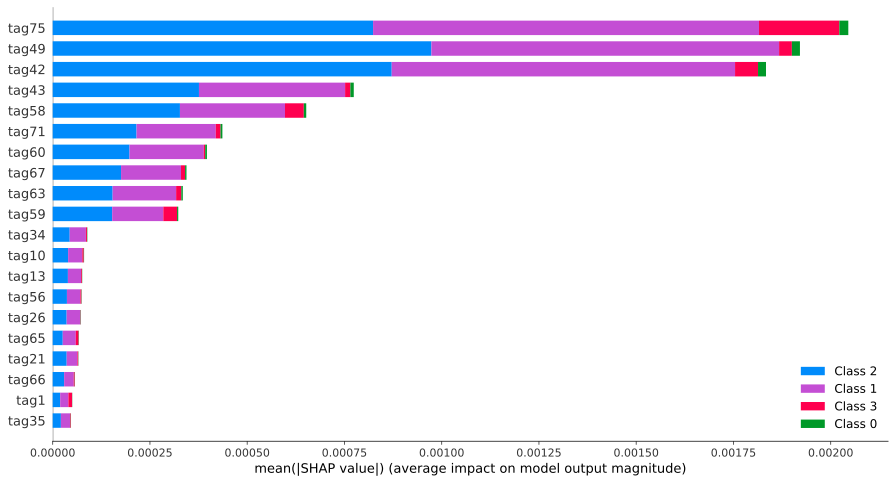

In [25]:
explainer = shap.TreeExplainer(ranforreg)
shap_values = explainer.shap_values(train_all_x.loc[:100,:])
shap.summary_plot(shap_values, train_all_x.loc[:100,:], plot_size=(15,8))

Более подробная информация о важности признаков

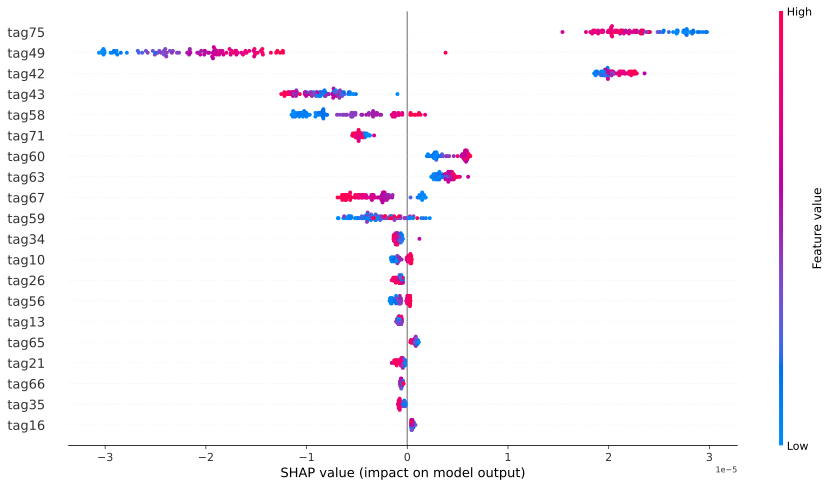

In [26]:
explainer = shap.TreeExplainer(ranforreg)
shap_values = explainer.shap_values(train_all_x.loc[:100,:])
shap.summary_plot(shap_values[0], train_all_x.loc[:100,:], plot_size=(15,8))